In [2]:
from tsai.all import *
from tsai.basics import *
device = "cuda" if torch.cuda.is_available() else 'cpu'
import torch
import torch.nn as nn
import torch.fft as fft
from tslearn.metrics import SoftDTWLossPyTorch

class BasePerturbation(nn.Module):
    def forward(self, x):
        raise NotImplementedError

    def regularization(self, x, x_cf):
        return torch.tensor(0., device=x.device)


class TimeL2Perturbation(BasePerturbation):
    def __init__(self, C, T, init_scale=1e-3):
        super().__init__()
        self.delta = nn.Parameter(init_scale * torch.randn(1, C, T))

    def forward(self, x):
        return x + self.delta

    def regularization(self, x, x_cf):
        #return self.delta.pow(2).mean()
        return self.delta.abs().sum()



class FrequencyPerturbation(BasePerturbation):
    def __init__(self, C, T, init_scale=1e-3):
        super().__init__()
        self.delta_real = nn.Parameter(init_scale * torch.randn(1, C, T))
        self.delta_imag = nn.Parameter(init_scale * torch.randn(1, C, T))

    def forward(self, x):
        X = torch.fft.fft(x, dim=-1, norm="ortho")
        delta = self.delta_real + 1j * self.delta_imag
        X_cf = X + delta
        x_ifft = torch.fft.ifft(X_cf, dim=-1, norm="ortho")
        return torch.view_as_real(x_ifft)[..., 0]

    def regularization(self, x, x_cf):
        return (
            self.delta_real.pow(2).mean() +
            self.delta_imag.pow(2).mean()
        )



class STFTPerturbation(BasePerturbation):
    def __init__(
        self,
        C,
        T,
        n_fft=16,
        hop_length=None,
        win_length=None,
        init_scale=1e-2,
        window_fn=torch.hann_window,
    ):
        super().__init__()

        self.n_fft = n_fft
        self.hop_length = hop_length or n_fft // 4
        self.win_length = win_length or n_fft
        self.window = window_fn(self.win_length)

        # compute STFT shape
        dummy = torch.zeros(1, C, T)
        Z = torch.stft(
            dummy.view(-1, T),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            return_complex=True,
        )

        F, TT = Z.shape[-2], Z.shape[-1]

        # learnable perturbation in TF space
        self.delta_real = nn.Parameter(init_scale * torch.randn(1, C, F, TT))
        self.delta_imag = nn.Parameter(init_scale * torch.randn(1, C, F, TT))
        self.mask_logits = nn.Parameter(torch.randn(1, C, F, TT))
        self.N = C*F*TT

    def forward(self, x):
        """
        x: (B, C, T)
        """
        B, C, T = x.shape
        window = self.window.to(x.device)

        # STFT (merge B and C for efficiency)
        Z = torch.stft(
            x.view(B * C, T),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=window,
            return_complex=True,
        )

        Z = Z.view(B, C, *Z.shape[-2:])
        delta = (self.delta_real + 1j * self.delta_imag)*torch.sigmoid(self.mask_logits)
        Z_cf = Z + delta

        # inverse STFT
        x_cf = torch.istft(
            Z_cf.view(B * C, *Z_cf.shape[-2:]),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=window,
            length=T,
        )

        return x_cf.view(B, C, T)

    def regularization(self, x, x_cf):
        mask = torch.sigmoid(self.mask_logits)
        #return torch.svd(self.delta_real[0,0,:,:],compute_uv=False).S.sum
        return (
        mask.sum()/self.N +  # sparsity
        (self.delta_real * mask).abs().pow(2).sum()
    )
        # return (
        #     self.delta_real.abs().sum() +
        #     self.delta_imag.abs().sum()
        # )


class TSCounterfactualGenerator:
    def __init__(
        self,
        learner: TSClassifier,
        perturbation_cls,
        lam_perturb=1e-4,
        lam_time=0.0,
        lam_clf=1.0,
        lr=1e-2,
        steps=500,
        device=None,
        **perturb_kwargs
    ):
        self.learner = learner
        self.model = learner.model.eval()
        self.model.to(device)

        for p in self.model.parameters():
            p.requires_grad = False

        self.loss_func = learner.loss_func
        self.lam_perturb = lam_perturb
        self.lam_time = lam_time
        self.lam_clf = lam_clf
        self.lr = lr
        self.steps = steps

        self.device = device or learner.dls.device
        self.perturbation_cls = perturbation_cls
        self.perturb_kwargs = perturb_kwargs
        self.sdtw = SoftDTWLossPyTorch(gamma=0.1)

    def generate(self, x, target):
        x = x.to(self.device).float()
        target = target.to(self.device)

        B, C, T = x.shape

        perturb = self.perturbation_cls(C=C, T=T, **self.perturb_kwargs)
        perturb = perturb.to(self.device)

        opt = torch.optim.Adam(perturb.parameters(), lr=self.lr)
        #opt = torch.optim.AdamW(perturb.parameters(), lr=self.lr, weight_decay=0.01)
        #opt = torch.optim.LBFGS(perturb.parameters())

        losses = []

        for _ in tqdm(range(self.steps)):
            opt.zero_grad()

            x_cf = perturb(x)
            #print(x_cf.device)
            logits = self.model(x_cf)

            clf_loss = self.loss_func(logits, target)

            probas = torch.softmax(logits,dim=-1)
    
            pert_reg = perturb.regularization(x, x_cf)
            #print('pert_reg',pert_reg)
            #time_reg = self.sdtw(x_cf,x)#
            #time_reg = (x_cf - x).pow(2).sum()
            time_reg = (x_cf-x).abs().sum()

            cur_dist = float((x-x_cf).pow(2).sum())
            #print(cur_dist)


            lr_clf = self.lam_clf
            lr_perturb = self.lam_perturb
            lr_time = self.lam_time

            if self.lam_clf is None:
                lr_clf = max(1.5, cur_dist / 10.0)  # Start with smaller regularization
               #print(lr_clf)
            if self.lam_time is None:
                lr_time = 0.05#0.005#max(0.5, cur_dist / 100.0) 
            if self.lam_perturb is None:
                lr_perturb = 0.5#max(0.15, cur_dist / 100.0)   # Smaller step increases


            loss = lr_clf*(clf_loss**2) + lr_perturb * pert_reg**2 + lr_time * time_reg**2- 10*(-probas*torch.log(probas)).sum()**0.5
            loss.backward()
            opt.step()

            losses.append(loss.item())


            x_cf = torch.where((x_cf-x).abs().pow(2)<1e-3,x,x_cf)
        return {
            "x_cf": x_cf.detach(),
            "losses": losses,
            "perturbation": perturb
        }
    

    


"""
Validity metrics for counterfactual explanations.

These metrics evaluate whether the generated counterfactuals achieve
the desired prediction changes and cross decision boundaries effectively.
"""

import numpy as np
import torch
from typing import Union, Callable, Any


def prediction_change(original_ts: np.ndarray, 
                     counterfactual_ts: np.ndarray,
                     model: Callable,
                     target_class: int = None) -> float:
    """
    Measures whether the counterfactual changes the model's prediction.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
        model: Trained model for prediction
        target_class: Desired target class (if None, just check if prediction changed)
    
    Returns:
        1.0 if prediction changed to target class (or any change if target_class=None), 0.0 otherwise
    """
    original_pred = model(original_ts)
    cf_pred = model(counterfactual_ts)
    
    if hasattr(original_pred, 'numpy'):
        try:
            original_pred = original_pred.numpy()
        except:
            original_pred = original_pred.detach().cpu().numpy()
    if hasattr(cf_pred, 'numpy'):
        try:
            cf_pred = cf_pred.numpy()
        except:
            cf_pred = cf_pred.detach().cpu().numpy()
    
    # Get predicted classes
    if isinstance(original_pred, np.ndarray) and original_pred.ndim > 0:
        orig_class = np.argmax(original_pred) if original_pred.size > 1 else int(original_pred.item())
    else:
        orig_class = int(original_pred)
        
    if isinstance(cf_pred, np.ndarray) and cf_pred.ndim > 0:
        cf_class = np.argmax(cf_pred) if cf_pred.size > 1 else int(cf_pred.item())
    else:
        cf_class = int(cf_pred)
    
    if target_class is not None:
        return float(cf_class == target_class)
    else:
        return float(orig_class != cf_class)


def class_probability_confidence(counterfactual_ts: np.ndarray,
                                model: Callable,
                                target_class: int) -> float:
    """
    Evaluates the confidence of the model's prediction on the counterfactual.
    
    Args:
        counterfactual_ts: Generated counterfactual time series
        model: Trained model for prediction
        target_class: Target class for the counterfactual
    
    Returns:
        Probability/confidence score for the target class
    """
    cf_pred = model(counterfactual_ts)
    
    if hasattr(cf_pred, 'numpy'):
        try:
            cf_pred = cf_pred.numpy()
        except:
            cf_pred = cf_pred.detach().cpu().numpy()
    
    # Apply softmax if raw logits
    if cf_pred.max() > 1.0 or cf_pred.min() < 0.0:
        cf_pred = np.exp(cf_pred) / np.sum(np.exp(cf_pred), axis=-1, keepdims=True)
    
    # Handle both 1D and 2D prediction arrays
    if isinstance(cf_pred, np.ndarray) and cf_pred.size > 1:
        return float(cf_pred[0][target_class])
    else:
        return float(cf_pred)


def decision_boundary_distance(original_ts: np.ndarray,
                              counterfactual_ts: np.ndarray, 
                              model: Callable,
                              num_steps: int = 100) -> float:
    """
    Measures how far the counterfactual moves across the decision boundary.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
        model: Trained model for prediction
        num_steps: Number of interpolation steps to find boundary
    
    Returns:
        Distance from original point to decision boundary
    """
    original_pred = model(original_ts)
    cf_pred = model(counterfactual_ts)
    
    if hasattr(original_pred, 'numpy'):
        original_pred = original_pred.numpy()
    if hasattr(cf_pred, 'numpy'):
        cf_pred = cf_pred.numpy()
    
    # Get predicted classes
    if isinstance(original_pred, np.ndarray) and original_pred.size > 1:
        orig_class = np.argmax(original_pred)
    else:
        orig_class = int(original_pred)
        
    if isinstance(cf_pred, np.ndarray) and cf_pred.size > 1:
        cf_class = np.argmax(cf_pred)
    else:
        cf_class = int(cf_pred)
    
    # If no class change, return 0
    if orig_class == cf_class:
        return 0.0
    
    # Binary search for decision boundary
    low, high = 0.0, 1.0
    boundary_point = None
    
    for _ in range(num_steps):
        mid = (low + high) / 2.0
        interpolated = (1 - mid) * original_ts + mid * counterfactual_ts
        pred = model(interpolated)
        
        if hasattr(pred, 'numpy'):
            pred = pred.numpy()
        
        if isinstance(pred, np.ndarray) and pred.size > 1:
            pred_class = np.argmax(pred)
        else:
            pred_class = int(pred)
        
        if pred_class == orig_class:
            low = mid
        else:
            high = mid
            boundary_point = interpolated
    
    if boundary_point is not None:
        return float(np.linalg.norm(boundary_point - original_ts))
    else:
        return float(np.linalg.norm(counterfactual_ts - original_ts))



In [3]:
"""
Proximity/Distance metrics for counterfactual explanations.

These metrics measure how close the counterfactual is to the original
time series using various distance measures suitable for time series data.
"""

import numpy as np
from typing import Optional
from scipy.spatial.distance import euclidean, mahalanobis as scipy_mahalanobis
try:
    from dtaidistance import dtw
    DTW_AVAILABLE = True
except ImportError:
    DTW_AVAILABLE = False


def l2_distance(original_ts: np.ndarray, counterfactual_ts: np.ndarray) -> float:
    """
    Calculates the Euclidean (L2) distance between original and counterfactual time series.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
    
    Returns:
        L2 distance between the time series
    """
    return float(np.linalg.norm(original_ts - counterfactual_ts))


def manhattan_distance(original_ts: np.ndarray, counterfactual_ts: np.ndarray) -> float:
    """
    Calculates the Manhattan (L1) distance between original and counterfactual time series.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
    
    Returns:
        Manhattan distance between the time series
    """
    return float(np.sum(np.abs(original_ts - counterfactual_ts)))


def dtw_distance(original_ts: np.ndarray, counterfactual_ts: np.ndarray) -> float:
    """
    Calculates Dynamic Time Warping distance accounting for temporal alignment.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
    
    Returns:
        DTW distance between the time series
    """
    if not DTW_AVAILABLE:
        raise ImportError("dtaidistance package is required for DTW distance. Install with: pip install dtaidistance")
    
    # Flatten if multidimensional
    if original_ts.ndim > 1:
        original_flat = original_ts.flatten()
        cf_flat = counterfactual_ts.flatten()
    else:
        original_flat = original_ts
        cf_flat = counterfactual_ts
    
    return float(dtw.distance(original_flat, cf_flat))


def frechet_distance(original_ts: np.ndarray, counterfactual_ts: np.ndarray) -> float:
    """
    Calculates discrete Fréchet distance considering ordering and flow of time series.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
    
    Returns:
        Fréchet distance between the time series
    """
    def _discrete_frechet_distance(P: np.ndarray, Q: np.ndarray) -> float:
        """
        Compute discrete Fréchet distance between two curves.
        """
        n, m = len(P), len(Q)
        
        # Initialize memoization matrix
        memo = {}
        
        def _c(i: int, j: int) -> float:
            if (i, j) in memo:
                return memo[(i, j)]
            
            if i == 0 and j == 0:
                result = np.linalg.norm(P[0] - Q[0])
            elif i > 0 and j == 0:
                result = max(_c(i-1, 0), np.linalg.norm(P[i] - Q[0]))
            elif i == 0 and j > 0:
                result = max(_c(0, j-1), np.linalg.norm(P[0] - Q[j]))
            elif i > 0 and j > 0:
                result = max(
                    min(_c(i-1, j), _c(i-1, j-1), _c(i, j-1)),
                    np.linalg.norm(P[i] - Q[j])
                )
            else:
                result = float('inf')
            
            memo[(i, j)] = result
            return result
        
        return _c(n-1, m-1)
    
    # Convert to 2D points if 1D
    if original_ts.ndim == 1:
        P = np.column_stack([np.arange(len(original_ts)), original_ts])
        Q = np.column_stack([np.arange(len(counterfactual_ts)), counterfactual_ts])
    else:
        P = original_ts
        Q = counterfactual_ts
    
    return float(_discrete_frechet_distance(P, Q))


def normalized_distance(original_ts: np.ndarray, 
                       counterfactual_ts: np.ndarray,
                       distance_func: callable = l2_distance) -> float:
    """
    Calculates normalized distance based on the range of the original time series.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
        distance_func: Distance function to use (default: l2_distance)
    
    Returns:
        Normalized distance between 0 and 1
    """
    raw_distance = distance_func(original_ts, counterfactual_ts)
    ts_range = np.max(original_ts) - np.min(original_ts)
    
    if ts_range == 0:
        return 0.0 if raw_distance == 0 else 1.0
    
    # Normalize by the maximum possible distance (range * sqrt(length))
    max_possible_distance = ts_range * np.sqrt(len(original_ts))
    return float(min(raw_distance / max_possible_distance, 1.0))


def mahalanobis_distance(original_ts: np.ndarray, 
                         counterfactual_ts: np.ndarray,
                         reference_data: Optional[np.ndarray] = None,
                         regularization: float = 1e-6) -> float:
    """
    Calculates the Mahalanobis distance between original and counterfactual time series.
    
    The Mahalanobis distance accounts for the covariance structure in the data, making it
    particularly useful when features/time points are correlated or have different scales.
    
    Args:
        original_ts: Original time series data (1D or flattened)
        counterfactual_ts: Generated counterfactual time series (1D or flattened)
        reference_data: Reference dataset to compute covariance matrix from.
                       Shape should be (n_samples, n_features) where n_features matches
                       the flattened length of the time series. If None, uses the
                       identity matrix (equivalent to Euclidean distance).
        regularization: Small value added to diagonal of covariance matrix for numerical
                       stability (default: 1e-6)
    
    Returns:
        Mahalanobis distance between the time series
    
    Raises:
        ValueError: If time series shapes don't match or reference data has wrong shape
    
    Example:
        >>> original = np.array([1.0, 2.0, 3.0])
        >>> counterfactual = np.array([1.5, 2.5, 3.5])
        >>> reference = np.random.randn(100, 3)
        >>> dist = mahalanobis_distance(original, counterfactual, reference)
    """
    # Flatten if multidimensional
    if original_ts.ndim > 1:
        original_flat = original_ts.flatten()
        cf_flat = counterfactual_ts.flatten()
    else:
        original_flat = original_ts
        cf_flat = counterfactual_ts
    
    if original_flat.shape != cf_flat.shape:
        raise ValueError(f"Time series shapes must match: {original_flat.shape} vs {cf_flat.shape}")
    
    # Compute difference vector
    diff = original_flat - cf_flat
    
    # Compute or use covariance matrix
    if reference_data is None:
        # Without reference data, use identity matrix (reduces to Euclidean distance)
        return float(np.sqrt(np.sum(diff ** 2)))
    
    # Ensure reference data is 2D
    if reference_data.ndim == 1:
        reference_data = reference_data.reshape(1, -1)
    
    # Flatten reference data if needed
    if reference_data.ndim > 2:
        n_samples = reference_data.shape[0]
        reference_data = reference_data.reshape(n_samples, -1)
    
    # Check dimensions
    if reference_data.shape[1] != len(original_flat):
        raise ValueError(
            f"Reference data feature dimension ({reference_data.shape[1]}) "
            f"must match time series length ({len(original_flat)})"
        )
    
    # Compute covariance matrix
    try:
        cov_matrix = np.cov(reference_data, rowvar=False)
        
        # Add regularization for numerical stability
        if cov_matrix.ndim == 0:
            # Single feature case
            cov_matrix = np.array([[cov_matrix + regularization]])
        else:
            cov_matrix += np.eye(cov_matrix.shape[0]) * regularization
        
        # Compute inverse covariance matrix
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        
        # Calculate Mahalanobis distance
        mahal_dist = np.sqrt(diff @ inv_cov_matrix @ diff.T)
        
        return float(mahal_dist)
        
    except np.linalg.LinAlgError:
        # If covariance matrix is singular even after regularization,
        # fall back to Euclidean distance
        import warnings
        warnings.warn(
            "Covariance matrix is singular. Falling back to Euclidean distance.",
            RuntimeWarning
        )
        return float(np.sqrt(np.sum(diff ** 2)))


__all__ = [
    'l2_distance', 
    'manhattan_distance', 
    'dtw_distance', 
    'frechet_distance',
    'normalized_distance',
    'mahalanobis_distance'
]



def spectral_similarity(original_ts: np.ndarray,
                       counterfactual_ts: np.ndarray) -> float:
    """
    Compares frequency domain characteristics of original and counterfactual.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
    
    Returns:
        Spectral similarity score (0 = completely different, 1 = identical)
    """
    if original_ts.ndim > 1:
        orig_flat = original_ts.flatten()
        cf_flat = counterfactual_ts.flatten()
    else:
        orig_flat = original_ts
        cf_flat = counterfactual_ts
    
    # Compute power spectral density
    orig_fft = np.abs(np.fft.fft(orig_flat))
    cf_fft = np.abs(np.fft.fft(cf_flat))
    
    # Normalize
    orig_fft = orig_fft / np.sum(orig_fft)
    cf_fft = cf_fft / np.sum(cf_fft)
    
    # Calculate similarity using correlation
    similarity = np.corrcoef(orig_fft, cf_fft)[0, 1]
    return float(max(0.0, similarity))

In [ ]:
##load data

dataname = 'ItalyPowerDemand'
X, y, splits = get_classification_data(dataname, split_data=False)
model_name = 'HydraPlus'


try:

    clf = load_learner(f"../models/{model_name}-{dataname}.pkl",cpu=False)
except:
    tfms = [None, TSClassification()]
    batch_tfms = TSStandardize()
    clf = TSClassifier(X, y, splits=splits, path='../models', arch=model_name, tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph(),device=device)
    clf.fit_one_cycle(100, 3e-4)
    clf.export(f"{model_name}-{dataname}.pkl")



cf_gen = TSCounterfactualGenerator(
    clf,
    perturbation_cls=STFTPerturbation,
    lam_time=None,#0.25,
    lam_clf=3,#5,
    steps=500,
    hop_length=1,
    n_fft=int(X.shape[2]//16),
    device=device,
    init_scale=1e-6,

)


METRICS = {'l2':l2_distance,'l1':manhattan_distance,'fid':frechet_distance,'validity':prediction_change,'target_class_proba':class_probability_confidence}

#validity = []
#target_class_proba = []
metrics = {'l2':[],'l1':[],'fid':[],'validity':[],'target_class_proba':[]}

for i in tqdm(range(X.shape[0])):

    x = torch.tensor(X[i]).unsqueeze(0).to(device)  # (1, C, T)


    probabilitis = torch.softmax(clf.model(x),dim=-1)

    target = torch.sort(probabilitis,descending=True)[1][0][1].to(device)


    cf = cf_gen.generate(x, target)

    x_cf = cf["x_cf"]


    #validity.append(prediction_change(x.detach(),x_cf.detach(),clf.model,target.reshape(-1,1).detach()[0]))

    #target_class_proba.append(class_probability_confidence(x_cf.detach(),clf.model,target.reshape(-1,1).detach()[0]))


    for k,f_dist in METRICS.items():
        if k in ['l2','l1','fid']:
            metrics[k].append(f_dist(x.detach().cpu().numpy(),x_cf.detach().cpu().numpy()))
        elif k =='validity':
            metrics[k].append(prediction_change(x.detach(),x_cf.detach(),clf.model,target.reshape(-1,1).detach()[0]))
        elif k == 'target_class_proba':
            metrics[k].append(class_probability_confidence(x_cf.detach(),clf.model,target.reshape(-1,1).detach()[0]))





100%|██████████| 200/200 [14:44<00:00,  4.42s/it]


tensor([[0.6122, 0.3878]], device='cuda:0')


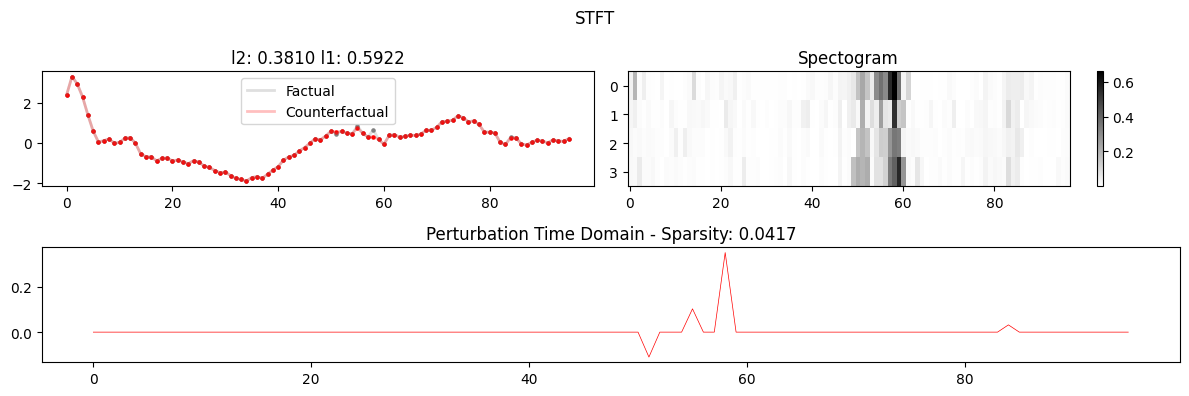

In [138]:
fig = plt.figure(figsize=(12,4))
fig.suptitle("STFT")
ax0 = fig.add_subplot(221)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=2.0,alpha=0.25)
ax0.plot(x_cf.detach().cpu().flatten(),label='Counterfactual',c='red',lw=2.0,alpha=0.25)
ax0.scatter(np.arange(x.shape[2]),x.detach().cpu().numpy().flatten(),marker='o',color='gray',s=5)
ax0.scatter(np.arange(x.shape[2]),x_cf.detach().cpu().flatten(),marker='o',color='red',s=5)
#ax0.set_title(f"DTW: {cf_gen.sdtw(x_cf,x).detach().cpu().numpy()[0]:.4f}")
ax0.set_title(f"l2: {(x_cf-x).pow(2).sum().detach().cpu().numpy()**0.5:.4f} l1: {(x_cf-x).abs().sum().detach().cpu().numpy():.4f}")
ax0.legend()
ax1 = fig.add_subplot(222)



try:
    im = ax1.imshow(cf['perturbation'].delta_real.detach().abs().cpu().numpy()[0,0,:,:],cmap='binary',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
except:
    #ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
    im = ax1.imshow(torch.stft(cf['perturbation'].delta.squeeze(0),n_fft=x.shape[2]//2,hop_length=4,return_complex=True)[0,:,:].detach().abs().cpu().numpy().real,cmap='binary',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title(f'Perturbation Time Domain - Sparsity: {((x_cf!=x).sum()/x.shape[2]).detach().cpu().numpy():.4f}')
ax2.plot(x.detach().cpu().numpy().flatten()-x_cf.detach().cpu().numpy().flatten(),color='red',lw=0.5)
# #ax2.set_yscale('log')
print(torch.softmax(clf.model(x_cf.detach().to(device)),1))
fig.tight_layout()

In [137]:
metrics

{'l2': [1.8328473567962646,
  1.7801543474197388,
  1.7874022722244263,
  3.191873550415039,
  1.2560935020446777,
  1.4449896812438965,
  2.5157251358032227,
  1.4752556085586548,
  1.3523499965667725,
  1.1008179187774658,
  0.6621582508087158,
  0.5181900858879089,
  0.9599027633666992,
  1.9529606103897095,
  2.956768274307251,
  1.3463183641433716,
  1.4428671598434448,
  1.7944916486740112,
  1.9386652708053589,
  2.3601598739624023,
  0.8522915840148926,
  1.0244945287704468,
  1.5812550783157349,
  3.3173787593841553,
  2.153367042541504,
  0.9055511951446533,
  1.179574728012085,
  2.5445964336395264,
  0.941307544708252,
  1.69725501537323,
  1.6974228620529175,
  1.6107103824615479,
  0.9742048978805542,
  1.9840528964996338,
  1.615708589553833,
  3.250751256942749,
  1.475812315940857,
  1.7617759704589844,
  0.7446947693824768,
  1.638331651687622,
  0.3351321518421173,
  0.7976048588752747,
  1.918302059173584,
  2.4646098613739014,
  1.6412450075149536,
  1.753043889999

### BATCH

In [ ]:
import torch
import torch.nn as nn

class BasePerturbation(nn.Module):
    """
    Base class for batched perturbations.

    All subclasses MUST:
      - accept batched inputs (B, C, T)
      - return batched outputs (B, C, T)
      - return per-sample regularization of shape (B,)
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, T)
        return: (B, C, T)
        """
        raise NotImplementedError

    def regularization(self) -> torch.Tensor:
        """
        Returns:
            reg: (B,) tensor
        """
        # Safe default: zero regularization per sample
        return torch.zeros(
            getattr(self, "B", 1),
            device=next(self.parameters()).device
            if len(list(self.parameters())) > 0
            else "cpu",
        )
    

    import torch
import torch.nn as nn

class STFTPerturbation(BasePerturbation):
    def __init__(
        self,
        B,
        C,
        T,
        n_fft=16,
        hop_length=None,
        win_length=None,
        init_scale=1e-2,
        window_fn=torch.hann_window,
    ):
        super().__init__()

        self.B = B
        self.C = C
        self.T = T
        self.n_fft = n_fft
        self.hop_length = hop_length or n_fft // 4
        self.win_length = win_length or n_fft
        self.window = window_fn(self.win_length)

        # Compute STFT shape
        dummy = torch.zeros(1, T)
        Z = torch.stft(
            dummy,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            return_complex=True,
        )
        F, TT = Z.shape[-2], Z.shape[-1]
        self.F,self.TT = F,TT

        # Per-sample learnable perturbation
        self.delta_real = nn.Parameter(init_scale * torch.randn(B, C, F, TT))
        self.delta_imag = nn.Parameter(init_scale * torch.randn(B, C, F, TT))
        self.mask_logits = nn.Parameter(torch.randn(B, C, F, TT))

        self.N = C * F * TT

    def forward(self, x):
        """
        x: (B, C, T)
        """
        B, C, T = x.shape
        window = self.window.to(x.device)

        # STFT
        Z = torch.stft(
            x.view(B * C, T),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=window,
            return_complex=True,
        )
        Z = Z.view(B, C, *Z.shape[-2:])

        mask = torch.sigmoid(self.mask_logits)
        delta = (self.delta_real + 1j * self.delta_imag) * mask
        Z_cf = Z + delta

        # inverse STFT
        x_cf = torch.istft(
            Z_cf.view(B * C, *Z_cf.shape[-2:]),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=window,
            length=T,
        )

        return x_cf.view(B, C, T)

    def regularization(self):
        """
        Returns: (B,)
        """
        mask = torch.sigmoid(self.mask_logits)

        sparsity = mask.sum(dim=(1, 2, 3)) / self.N
        energy = ((self.delta_real * mask) ** 2).sum(dim=(1, 2, 3))

        return sparsity + energy
    



    from tqdm import tqdm

class TSCounterfactualGenerator:
    def __init__(
        self,
        learner,
        perturbation_cls,
        lam_perturb=1e-4,
        lam_time=0.0,
        lam_clf=1.0,
        lam_entropy=20,
        lr=1e-2,
        steps=500,
        device=None,
        **perturb_kwargs
    ):
        self.learner = learner
        self.model = learner.model.eval()
        self.device = device or learner.dls.device
        self.model.to(self.device)

        for p in self.model.parameters():
            p.requires_grad = False

        self.loss_func = learner.loss_func
        self.lam_perturb = lam_perturb
        self.lam_time = lam_time
        self.lam_clf = lam_clf
        self.lam_entropy = lam_entropy
        self.lr = lr
        self.steps = steps

        self.perturbation_cls = perturbation_cls
        self.perturb_kwargs = perturb_kwargs

    def generate(self, x, target):
        """
        x: (B, C, T)
        target: (B,)
        """
        x = x.to(self.device).float()
        target = target.to(self.device)

        B, C, T = x.shape

        perturb = self.perturbation_cls(
            B=B, C=C, T=T, **self.perturb_kwargs
        ).to(self.device)

        opt = torch.optim.Adam(perturb.parameters(), lr=self.lr)

        print(perturb.parameters[0].shape)
        for param in perturb.parameters():
            print(param.shape)
        losses = []

        #Original
        logits_orig = self.model(x)
        y_orig = logits_orig.argmax(dim=1)   # (B,)


        for _ in tqdm(range(self.steps)):
            opt.zero_grad()

            # Counterfactual
            x_cf = perturb(x)
            logits = self.model(x_cf)


            #Classification loss (per-sample)
            clf_loss = self.loss_func(logits, target)

            # Distance regularization
            time_reg = (x_cf - x).abs().sum(dim=(1, 2))

            # Perturbation regularization
            pert_reg = perturb.regularization()

            # Entropy (encourage confident predictions)
            probas = torch.softmax(logits, dim=-1)
            entropy = (-(probas * torch.log(probas + 1e-8)).sum(dim=1))#.pow(0.5)

            # p_orig = probas.gather(1, y_orig[:, None]).squeeze(1)   # (B,)
            # p_tgt  = probas.gather(1, target[:, None]).squeeze(1)   # (B,)
            # #Normalize to probability dist
            # p_pair = torch.stack([p_orig, p_tgt], dim=1)             # (B, 2)
            # p_pair = p_pair / (p_pair.sum(dim=1, keepdim=True) + 1e-8)
            # entropy = -(p_pair * torch.log(p_pair + 1e-8)).sum(dim=1)  # (B,)

            # Adaptive lambdas (optional)
            lr_clf = self.lam_clf if self.lam_clf is not None else 1.0
            lr_time = self.lam_time if self.lam_time is not None else 0.05
            lr_perturb = self.lam_perturb if self.lam_perturb is not None else 0.5
            lr_entropy = self.lam_entropy if self.lam_entropy is not None else 20

            # Total loss (mean over batch)
            loss = (
                lr_clf * clf_loss.pow(2)
                + lr_perturb * pert_reg.pow(2)
                + lr_time * time_reg.pow(2)
                - lr_entropy * entropy
            ).sum()

            loss.backward()
            opt.step()

            losses.append(loss.item())

            # Small-change snapping (optional)
            x_cf = torch.where(
                (x_cf - x).pow(2) < 1e-5, x, x_cf
            )

        return {
            "x_cf": x_cf.detach(),
            "losses": losses,
            "perturbation": perturb,
        }




In [ ]:
dataname = 'CricketX'
X, y, splits = get_classification_data(dataname, split_data=False)
X_norm = (np.array(X.tolist())[:,0,:]-np.array(X.tolist())[:,0,:].mean(axis=0))/(np.array(X.tolist())[:,0,:].std(axis=0))


array([[-0.92082601, -0.82873291, -1.09974767, ..., -0.58043315,
        -0.57026321, -0.87771059],
       [-1.03525328, -1.30030595, -1.30783257, ..., -1.48195251,
        -1.20686107, -1.17199006],
       [ 1.00890722,  1.12927   ,  1.097207  , ...,  1.67860222,
         1.40061173,  1.74128113],
       ...,
       [-0.85126232, -0.11019026, -0.36241228, ...,  1.15874565,
         1.38073893,  1.12416297],
       [-0.7174977 , -0.59757724, -0.61244379, ..., -0.74990783,
        -0.92121415, -0.75090464],
       [ 0.6671874 ,  0.15785249,  0.80985715, ...,  1.09894686,
         1.10271342,  1.24112373]])

In [17]:
dataname ='ItalyPowerDemand'
dataname = 'Coffee'
X, y, splits = get_classification_data(dataname, split_data=False)
X_norm = (np.array(X.tolist())[:,0,:]-np.array(X.tolist())[:,0,:].mean(axis=0))/(np.array(X.tolist())[:,0,:].std(axis=0))

X= X_norm[:,np.newaxis,:]
model_name = 'HydraPlus'


try:

    clf = load_learner(f"../models/{model_name}-{dataname}.pkl",cpu=False)
except:
    tfms = [None, TSClassification()]
    batch_tfms = TSStandardize()
    clf = TSClassifier(X, y, splits=splits, path='../models', arch=model_name, tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph(),device=device)
    clf.fit_one_cycle(100, 3e-4)
    clf.export(f"{model_name}-{dataname}.pkl")






METRICS = {
    'l2': l2_distance,
    'l1': manhattan_distance,
    'fid': frechet_distance,
    'validity': prediction_change,
    'target_class_proba': class_probability_confidence,
    'spectral_similarity':spectral_similarity
}

metrics = {k: [] for k in METRICS}



cf_gen = TSCounterfactualGenerator(
    clf,
    perturbation_cls=STFTPerturbation,
    lam_time=0.05,
    lam_perturb=0.5,
    lam_clf=5*len(set(y.tolist())),
    lam_entropy = 5*len(set(y.tolist())),
    steps=1000,
    hop_length=1,
    n_fft=int(X.shape[2] // 8),
    device=device,
    init_scale=1e-6,
)

N = X.shape[0]

BATCH_SIZE=64

for start in tqdm(range(0, N, BATCH_SIZE)):
    end = min(start + BATCH_SIZE, N)

    # ------------------------------------------------
    # Batch inputs
    # ------------------------------------------------
    x = torch.tensor(X[start:end]).to(device).float()  # (B, C, T)

    # ------------------------------------------------
    # Compute batch targets (2nd most probable class)
    # ------------------------------------------------
    with torch.no_grad():
        probas = torch.softmax(clf.model(x), dim=-1)
        target = torch.topk(probas, k=2, dim=-1).indices[:, 1]  # (B,)

    # ------------------------------------------------
    # Generate counterfactuals (batched!)
    # ------------------------------------------------
    cf = cf_gen.generate(x, target)
    x_cf = cf["x_cf"]

    # ------------------------------------------------
    # Metric computation (per sample)
    # ------------------------------------------------
    x_np = x.detach().cpu().numpy()
    x_cf_np = x_cf.detach().cpu().numpy()

    for i in range(x_np.shape[0]):
        xi = x_np[i:i+1]
        xcf_i = x_cf_np[i:i+1]
        ti = target[i].detach()

        for k, f_dist in METRICS.items():
            if k in ['l2', 'l1', 'fid']:
                metrics[k].append(f_dist(xi, xcf_i))

            elif k == 'validity':
                metrics[k].append(
                    prediction_change(
                        torch.tensor(xi).to(device),
                        torch.tensor(xcf_i).to(device),
                        clf.model,
                        ti
                    )
                )

            elif k == 'target_class_proba':
                metrics[k].append(
                    class_probability_confidence(
                        torch.tensor(xcf_i).to(device),
                        clf.model,
                        ti
                    )
                )

            elif k == 'spectral_similarity':
                metrics[k].append(spectral_similarity(xi,xcf_i))
            


  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: 'method' object is not subscriptable

In [109]:
for _,v in metrics.items():
    print(_,np.mean(v))

l2 1.443923995483422
l1 3.5924891086607955
fid 1.443923995483422
validity 0.9251824817518248
target_class_proba 0.6546872254889322
spectral_similarity 0.9196195341593938


In [9]:
for _,v in metrics.items():
    print(_,np.mean(v))

l2 1.844344176352024
l1 8.567533365317754
fid 1.844344176352024
validity 0.8571428571428571
target_class_proba 0.6066159727322104
spectral_similarity 0.9943096684553645


tensor([[0.1976, 0.8024]], device='cuda:0')


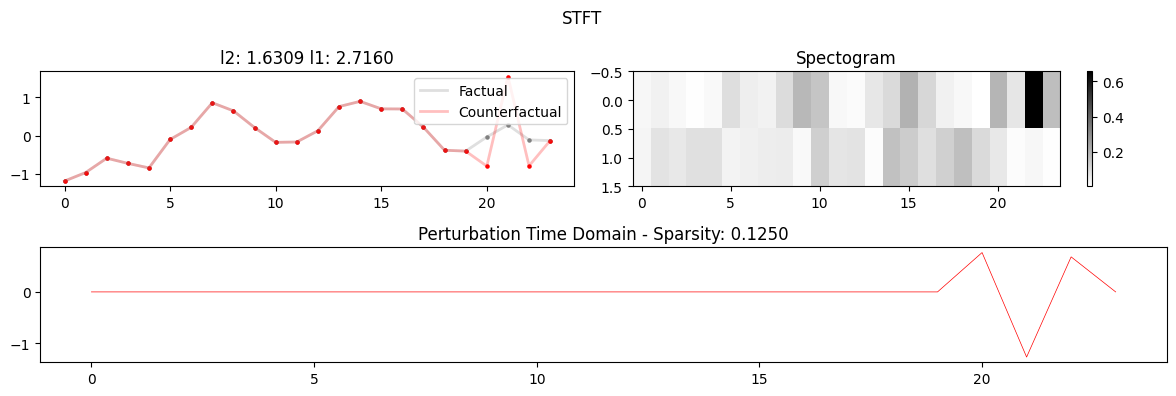

In [7]:
j = 5


fig = plt.figure(figsize=(12,4))
fig.suptitle("STFT")
ax0 = fig.add_subplot(221)
ax0.plot(x[j].detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=2.0,alpha=0.25)
ax0.plot(x_cf[j].detach().cpu().flatten(),label='Counterfactual',c='red',lw=2.0,alpha=0.25)
ax0.scatter(np.arange(x.shape[2]),x[j].detach().cpu().numpy().flatten(),marker='o',color='gray',s=5)
ax0.scatter(np.arange(x.shape[2]),x_cf[j].detach().cpu().flatten(),marker='o',color='red',s=5)
#ax0.set_title(f"DTW: {cf_gen.sdtw(x_cf,x).detach().cpu().numpy()[0]:.4f}")
ax0.set_title(f"l2: {(x_cf[j]-x[j]).pow(2).sum().detach().cpu().numpy()**0.5:.4f} l1: {(x_cf[j]-x[j]).abs().sum().detach().cpu().numpy():.4f}")
ax0.legend()
ax1 = fig.add_subplot(222)



im = ax1.imshow(cf['perturbation'].delta_real[j].detach().abs().cpu().numpy()[0,:,:],cmap='binary',aspect='auto')
fig.colorbar(im)
ax1.set_title('Spectogram')

#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title(f'Perturbation Time Domain - Sparsity: {((x_cf[j]!=x[j]).sum()/x.shape[2]).detach().cpu().numpy():.4f}')
ax2.plot(x[j].detach().cpu().numpy().flatten()-x_cf[j].detach().cpu().numpy().flatten(),color='red',lw=0.5)
# #ax2.set_yscale('log')
print(torch.softmax(clf.model(x_cf[j].reshape(1,1,-1).detach().to(device)),1))
fig.tight_layout()